In [1]:
import tensorflow as tf

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Polygon, Arrow
import itertools
import os 
import albumentations as albu
import cv2

def get_image(index, data, target_size, dataset_directory, normalize = True, transformer = None):

    while(1):
        image = cv2.imread(os.path.join(dataset_directory, data['image_path'].values[index].strip())) #dataset_directory + data['image_path'].values[index])
        labels = np.array([(data['tlx'].values[index], data['tly'].values[index]), (data['trx'].values[index], data['try'].values[index]), (data['brx'].values[index], data['bry'].values[index]), (data['blx'].values[index], data['bly'].values[index])])
        image = cv2.resize(image, target_size)

        if transformer is not None:
            if ((labels>1).any() or (labels <0).any()) == False:
                labels = labels*223
                outs = transformer(image = image, keypoints = labels)
                labels = np.array(outs['keypoints'])
                labels = labels/223.0
                if len(labels) != 4:
                    import pdb;pdb.set_trace()
                labels = labels.reshape((8))
            else:
#                 labels = labels*223
                labels = labels.reshape(8)
                delta = np.zeros(8)
                delta[labels>1] = labels[labels>1] - 1
                labels[labels>1] = 1
                delta[labels<0] = - labels[labels<0]
                labels[labels<0] = 0
                labels = labels.reshape((4,2))
                
                labels = labels*223
                delta = delta*223

                outs = transformer(image = image, keypoints = labels)
                
                labels = np.array(outs['keypoints'])
                labels = labels.reshape(8)
                labels[labels == 0] -= delta[labels == 0]
                labels[labels == 223] += delta[labels == 223]
                labels = labels/223.0
                
            image = outs['image']
            
        
        if normalize:
            image = image/255.0
        
        if len(labels) == 8:
            return [image, labels]
        else:
            continue



def generator(data, image_wh, batch_size, dataset_directory, normalize = True, transformer = None):
    while True:
        # Randomize the indices to make an array
        indices_arr = np.random.permutation(len(data))
        for batch in range(0, len(indices_arr), batch_size):
            # slice out the current batch according to batch-size
            current_batch = indices_arr[batch:(batch + batch_size)]

            # initializing the arrays, x_train and y_train
            x_train = np.empty([0, image_wh, image_wh, 3], dtype=np.float32)
            y_train = np.empty([0, 8], dtype=np.int32)

            for i in current_batch:
                [image, color] = get_image(i, data, (image_wh, image_wh), dataset_directory, normalize = normalize, transformer = transformer)
                x_train = np.append(x_train, [image], axis=0)
                y_train = np.append(y_train, [color], axis=0)

                # [image, color] = get_image(i, data, (image_wh, image_wh), dataset_directory, normalize = normalize)
                # x_train = np.append(x_train, [image], axis=0)
                # y_train = np.append(y_train, [color], axis=0)

            yield (x_train, y_train)

def create_transformer(transformations):
    return albu.Compose(transformations, p=1, keypoint_params=albu.KeypointParams(format='xy'))#(image=image, keypoints=points)


In [10]:
dataset_directory = './card_dataset_dummy_v4/test'
image_wh = 224
target_size = (image_wh, image_wh)
# valid_len = len(df) * 3 // 4
seed = 1
batch_size = 16 #@param {type:"integer"}
batch_size_valid = 8
df = pd.read_csv(os.path.join(dataset_directory, 'labels.csv'), header='infer')
df.drop(columns=['glare'], inplace=True)
labels = list(df)[1:]
filenames = list(df)[0]
train_len = len(df) // 2
trainDF = df
steps_per_epoch = len(df) // batch_size
transformer = create_transformer([
                                  albu.VerticalFlip(p=.5), 
                                  albu.HorizontalFlip(p=0.5),
                                  albu.Flip(p=0.5),
                                  albu.OneOf([albu.HueSaturationValue(p=0.5), albu.RGBShift(p=0.7)], p=1),
                                  albu.RandomBrightnessContrast(p=0.5)
                                  ])

In [11]:
train_generator = generator(trainDF, image_wh, batch_size, dataset_directory, transformer = transformer)


In [12]:
x, y = next(train_generator)

In [13]:
def vis_points(image, points, diameter=3):
    im = image.copy()
    points = points.reshape((4, 2))

    for (x, y) in points:
#     draw = points[0]
#     print(draw)
#     x, y = draw
        cv2.circle(im, (int(x), int(y)), diameter, (0, 255, 0), -1)

    plt.imshow(im)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-25.921504  156.378208  186.912768  162.393952  182.578592   47.428192
  -9.3528512  27.027616 ] 0


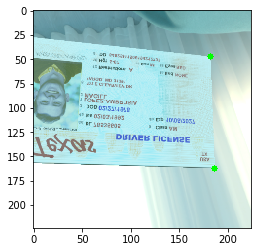

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 56.844704  52.604608 212.949408  63.056448 200.032448 155.14128
  54.701024 145.89008 ] 1


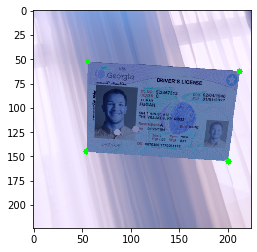

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 13.3672224 138.908     157.94576   152.530784  166.615008   66.065664
  24.40144    46.582816 ] 2


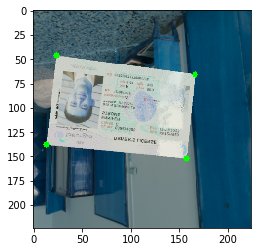

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 62.178368  25.22688  216.608224  76.332928 181.452096 173.920768
  30.274272 119.037184] 3


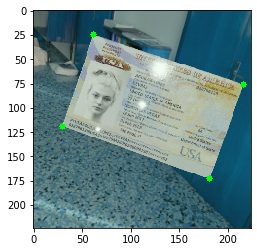

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[155.054368  33.022976  25.064704  88.605664  54.73664  169.574048
 189.369376 120.826048] 4


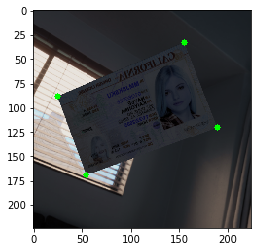

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[179.704672  74.865952  27.502272  87.779328  49.759136 161.913024
 181.822592 157.605952] 5


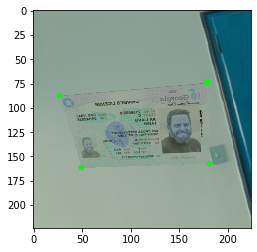

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[243.7160768  164.013696    27.246016   223.11821056   7.149856
  86.94784    196.908544    51.651936  ] 6


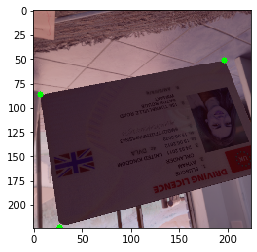

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[190.502368 171.312064  41.225632 178.949344  36.990464  84.905408
 186.32768   78.617056] 7


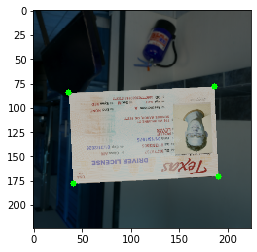

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[155.41008  164.120544  20.862688 134.158528  39.464992  51.439808
 173.2528    78.410976] 8


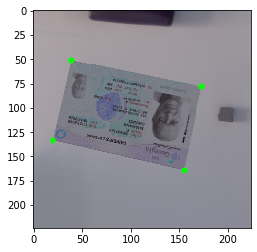

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-51.681728 121.89744  127.053024 284.25488  210.893984 161.878976
  49.788704  30.64768 ] 9


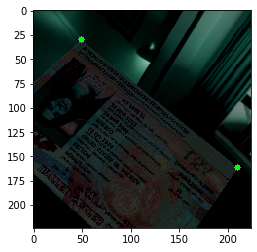

In [14]:
i = 0
for i in range(10):
    xo, yo = x[i], y[i]
    print(yo*224, i)
    vis_points(xo, yo*224)